Data visualization and transformation is an important part of every model. Now that we have our dataset downloaded, let's learn more about audio data visualization and transforming this dataset.

TorchAudio has many transformation functions for audio manipulation and feature extractions. However, in this module, your focus is on the following concepts and transforms: `Spectrogram`, `MelSpectrogram`, `Waveform`, and `MFCC`. After you understand these concepts, you'll create your spectrogram images of the yes/no dataset to be used in the computer vision model.

數據可視化和轉換是每個模型的重要部分。現在我們已經下載了數據集，讓我們更深入了解音訊數據的可視化和轉換。

TorchAudio 具有許多用於音訊操作和特徵提取的轉換函數。然而，在這個模組中，您的重點將放在以下概念和轉換上：`Spectrogram`、`MelSpectrogram`、`Waveform` 和 `MFCC`。在您理解了這些概念之後，您將創建「是/否」數據集的頻譜圖像，以供計算機視覺模型使用。

- **Spectrogram**: Create a spectrogram from a waveform.
- **MFCC**: Create the Mel-frequency cepstrum coefficients from a waveform.
- **MelSpectrogram**: Create Mel spectrograms from a waveform by using the `STFT` function in PyTorch.

- **Spectrogram（頻譜圖）**：從波形創建一個頻譜圖。
- **MFCC（梅爾倒頻譜係數）**：從波形創建梅爾頻率倒譜係數。
- **MelSpectrogram（梅爾頻譜圖）**：使用 PyTorch 中的 `STFT` 函數，從波形創建梅爾頻譜圖。

## Load the dataset folders into a data loader

Import the packages, and create a `load_audio_files` function to load audio files from a specified path into a dataset.

In [21]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

First, we'll go through the audio file that we downloaded in our local directory by filtering out the ones that are the `yes` and `no` commands under the _nohash_ path. Then we'll load the files into the `torchaudio` data object. This will make it easy to extract the attributes of the audio (for example, the waveform and sample rate).

In [22]:
def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        speaker_id, utterance_number = speaker.split("_nohash_")
        utterance_number = int(utterance_number)
    
        # Load audio
        waveform, sample_rate = torchaudio.load(file_path)
        dataset.append([waveform, sample_rate, label, speaker_id, utterance_number])
        
    return dataset

Call the `load_audio_files` function to load the contents from each of the audio class files, as well as their metadata.  

In [23]:
trainset_speechcommands_yes = load_audio_files('./data/SpeechCommands/speech_commands_v0.02/yes', 'yes')
trainset_speechcommands_no = load_audio_files('./data/SpeechCommands/speech_commands_v0.02/no', 'no')

In [24]:
print(f'Length of yes dataset: {len(trainset_speechcommands_yes)}')
print(f'Length of no dataset: {len(trainset_speechcommands_no)}')

Length of yes dataset: 4044
Length of no dataset: 3941


Now load the dataset into a data loader for both `yes` and `no` training sample sets. `DataLoader` sets the number of batches you want to iterate to load the dataset through your network, to train the model. We'll set the batch size to 1, because we want to load the entire batch in one iteration.

現在，將數據集加載到 yes 和 no 訓練樣本集的數據加載器中。 DataLoader 設置了您想要迭代以通過您的網絡加載數據集以訓練模型的批次數。我們將批次大小設置為1，因為我們希望在一次迭代中加載整個批次。

In [25]:
trainloader_yes = torch.utils.data.DataLoader(trainset_speechcommands_yes, batch_size=1,
                                            shuffle=True, num_workers=0)

In [26]:
trainloader_no = torch.utils.data.DataLoader(trainset_speechcommands_no, batch_size=1,
                                            shuffle=True, num_workers=0)

To see how the data looks, we'll grab the waveform and sample rate from each class, and print out a sample of the dataset.

- The **waveform** value is in a Tensor with a float datatype.
- The **sample rate** value is 16000 in the format the audio signal was captured.
- The **label** value is the command classification of the word uttered in the audio, `yes` or `no`.
- The **ID** is a unique identifier of the audio file.

為了查看數據的外觀，我們將從每個類別中獲取波形和取樣率，並打印出數據集的一個樣本。

- **波形（waveform）** 值是以浮點數數據類型存儲的張量。
- **取樣率（sample rate）** 值是以音訊信號捕捉格式的16000。
- **標籤（label）** 值是音訊中發音的單詞的命令分類，即 `yes` 或 `no`。
- **ID** 是音訊文件的唯一標識符。

In [27]:
yes_waveform = trainset_speechcommands_yes[0][0]
yes_sample_rate = trainset_speechcommands_yes[0][1]
print(f'Yes Waveform: {yes_waveform}')
print(f'Yes Sample Rate: {yes_sample_rate}')
print(f'Yes Label: {trainset_speechcommands_yes[0][2]}')
print(f'Yes ID: {trainset_speechcommands_yes[0][3]} \n')

no_waveform = trainset_speechcommands_no[0][0]
no_sample_rate = trainset_speechcommands_no[0][1]
print(f'No Waveform: {no_waveform}')
print(f'No Sample Rate: {no_sample_rate}')
print(f'No Label: {trainset_speechcommands_no[0][2]}')
print(f'No ID: {trainset_speechcommands_no[0][3]}')

Yes Waveform: tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]])
Yes Sample Rate: 16000
Yes Label: yes
Yes ID: 004ae714 

No Waveform: tensor([[0.0072, 0.0061, 0.0055,  ..., 0.0098, 0.0085, 0.0092]])
No Sample Rate: 16000
No Label: no
No ID: 012c8314


## Transform and visualize

Our data is ready! Let's break down some of the audio transforms and the visualization to better understand what they are, and what they tell us about the data.

### Waveform

The waveform is generated by taking the sample rate and frequency, and representing the signal visually. This signal can be represented as a `waveform`, which is the `signal` representation over time, in a graphical format. The audio can be recorded in different `channels`. For example, stereo recordings have two channels: right and left.

Here's how to use the `resample` transform to reduce the size of the waveform, and then graph the data to visualize the new waveform shape.

## 轉換和可視化

我們的數據已經準備好了！讓我們分解一些音訊轉換和可視化，以更好地理解它們是什麼，以及它們告訴我們有關數據的什麼信息。

### 波形（Waveform）

波形是通過取樣率和頻率來生成的，並以視覺方式表示信號。這個信號可以被表示為「波形」，即以圖形格式呈現的信號在時間上的表示。音訊可以以不同的「通道」記錄。例如，立體聲錄音有兩個通道：右聲道和左聲道。

以下是如何使用 `resample` 轉換來減小波形的大小，然後繪製數據以可視化新的波形形狀。

In [28]:
def show_waveform(waveform, sample_rate, label):
    print("Waveform: {}\nSample rate: {}\nLabels: {} \n".format(waveform, sample_rate, label))
    new_sample_rate = sample_rate/10
   
    # Resample applies to a single channel, we resample first channel here
    channel = 0
    waveform_transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel,:].view(1,-1))

    print("Shape of transformed waveform: {}\nSample rate: {}".format(waveform_transformed.size(), new_sample_rate))

    plt.figure()
    plt.plot(waveform_transformed[0,:].numpy())

The displayed results show how the sample rate is transformed from 16000 to 1600.

Waveform: tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]])
Sample rate: 16000
Labels: yes 

Shape of transformed waveform: torch.Size([1, 1600])
Sample rate: 1600.0


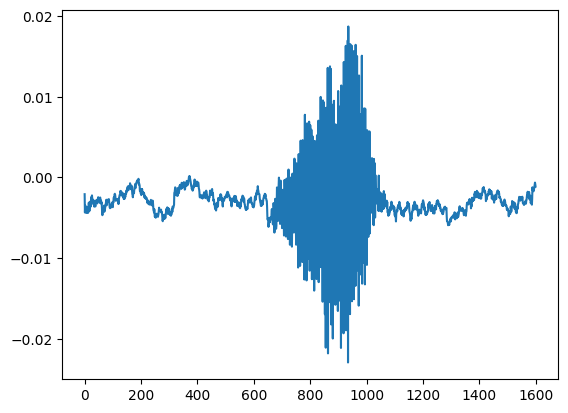

In [29]:
show_waveform(yes_waveform, yes_sample_rate, 'yes')

Waveform: tensor([[0.0072, 0.0061, 0.0055,  ..., 0.0098, 0.0085, 0.0092]])
Sample rate: 16000
Labels: no 

Shape of transformed waveform: torch.Size([1, 1600])
Sample rate: 1600.0


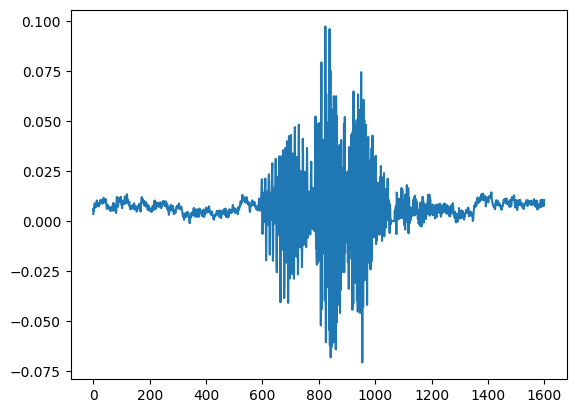

In [30]:
show_waveform(no_waveform, no_sample_rate, 'no')

## Spectrogram

So, what is a spectrogram? A spectrogram maps the frequency to time of an audio file, and it allows you to visualize audio data by frequency. It's in an image format. This image is what we'll use for our computer vision classification on the audio files. You can view the spectrogram image in grayscale, or in Red Green Blue (RGB) color format.

Every spectrogram image helps show the different features the sound signal produces in a color pattern. The convolutional neural network (CNN) treats the color patterns in the image as features for training the model to classify the audio.

Let's use the PyTorch `torchaudio.transforms` function to transform the waveform to a spectrogram image format.


## 頻譜圖（Spectrogram）

那麼，什麼是頻譜圖？頻譜圖將音訊文件的頻率映射到時間軸上，並允許您按頻率可視化音訊數據。它以圖像格式呈現。我們將使用這個圖像進行計算機視覺分類的音訊文件。您可以以灰度或紅綠藍（RGB）顏色格式查看頻譜圖像。

每個頻譜圖像都有助於展示聲音信號在顏色模式中產生的不同特徵。卷積神經網絡（CNN）將圖像中的顏色模式視為用於訓練模型對音訊進行分類的特徵。

讓我們使用 PyTorch 的 `torchaudio.transforms` 函數將波形轉換為頻譜圖像格式。

In [1]:
def show_spectrogram(waveform_classA, waveform_classB):
    yes_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classA)
    print("\nShape of yes spectrogram: {}".format(yes_spectrogram.size()))
    
    no_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classB)
    print("Shape of no spectrogram: {}".format(no_spectrogram.size()))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Features of {}".format('yes'))
    plt.imshow(yes_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
    
    plt.subplot(1, 2, 2)
    plt.title("Features of {}".format('no'))
    plt.imshow(no_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')

We'll use the waveform for the `yes` command to display the spectrogram images dimensions and color pattern in an RGB chart. We'll also compare the feature difference between the `yes` and `no` audio commands.

- The **y-axis** is the frequency of the audio.
- The **x-axis** is the time of the audio.
- The intensity of the image shows the amplitude of the audio. In the following spectrogram images, the high concentrate of the yellow color illustrates the amplitude of the audio.

我們將使用「是」命令的波形來顯示頻譜圖像的尺寸和RGB圖表中的顏色模式。我們還將比較「是」和「否」音頻命令之間的特徵差異。

- **y軸** 是音頻的頻率。
- **x軸** 是音頻的時間。
- 圖像的強度顯示了音訊的振幅。在以下的頻譜圖像中，黃色顏色的高集中度表示音訊的振幅。


Shape of yes spectrogram: torch.Size([1, 201, 81])
Shape of no spectrogram: torch.Size([1, 201, 81])


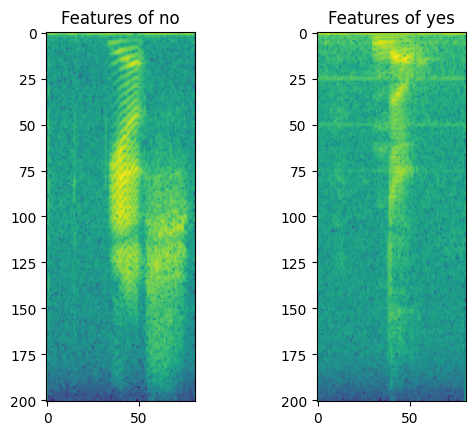

In [32]:
show_spectrogram(yes_waveform, no_waveform)

## Mel spectrogram

Mel spectrogram is also a frequency to time, but the frequency is converted to the Mel scale. The Mel scale takes the frequency and changes it, based on the perception of the sound of the scale or melody. This transforms the frequency within to the Mel scale, and then creates the spectrogram image.

## 梅爾頻譜圖（Mel Spectrogram）

梅爾頻譜圖也是一種將頻率映射到時間的表示，但頻率被轉換為梅爾刻度。梅爾刻度根據音階或旋律的聽覺感知來改變頻率。這將頻率轉換為梅爾刻度內的頻率，然後創建梅爾頻譜圖像。

In [33]:
def show_melspectrogram(waveform,sample_rate):
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mel_spectrogram.size()))

    plt.figure()
    plt.imshow(mel_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')

Shape of spectrogram: torch.Size([1, 128, 81])


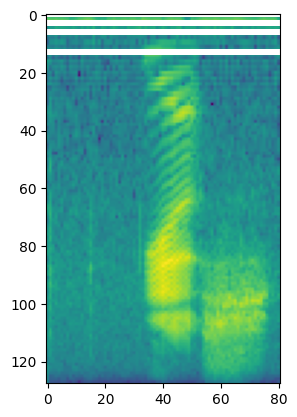

In [34]:
show_melspectrogram(yes_waveform, yes_sample_rate)

## Mel-frequency cepstral coefficients (MFCC)

A simplified explanation of what the MFCC does is that it takes our frequency, applies transforms, and the result is the amplitudes of the spectrum created from the frequency. Let's take a look at what this looks like.

## 梅爾倒頻譜係數（MFCC）

對於 MFCC 的簡化解釋是，它取得我們的頻率，應用轉換，結果是從頻率創建的頻譜的振幅。讓我們看看這是什麼樣子。

In [35]:
def show_mfcc(waveform,sample_rate):
    mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mfcc_spectrogram.size()))

    plt.figure()
    fig1 = plt.gcf()
    plt.imshow(mfcc_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
    
    plt.figure()
    plt.plot(mfcc_spectrogram.log2()[0,:,:].numpy())
    plt.draw()

Shape of spectrogram: torch.Size([1, 40, 81])


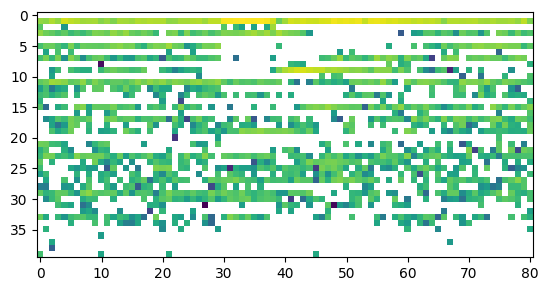

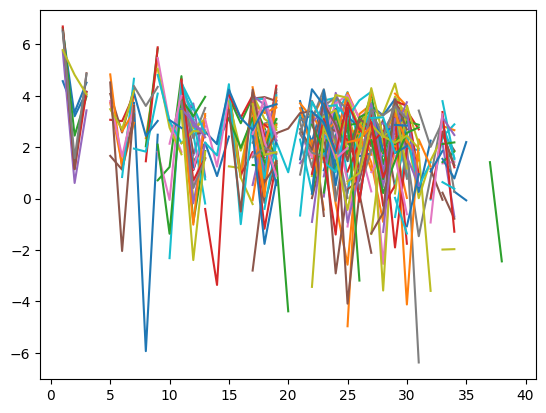

In [36]:
show_mfcc(no_waveform,  no_sample_rate)

## Create an image from a spectrogram

At this point, you have a better understanding of your audio data, and different transformations you can use on it. Now, let's create the images we will use for classification. 

The following are two different functions to create the spectrogram image or the MFCC images for classification. You'll use the spectrogram images to train our model. Feel free to play around with MFCC classification on your own, if you want to.

## 從頻譜圖創建圖像

到目前為止，您對音訊數據以及可以對其進行的不同轉換有了更好的了解。現在，讓我們創建用於分類的圖像。

以下是兩種不同的函數，用於創建用於分類的頻譜圖像或 MFCC 圖像。我們將使用頻譜圖像來訓練我們的模型。如果您想要的話，可以自行嘗試 MFCC 分類。

In [37]:
def create_spectrogram_images(trainloader, label_dir):
    #make directory
    directory = f'./data/spectrograms/{label_dir}/'
    if(os.path.isdir(directory)):
        print("Data exists for", label_dir)
    else:
        os.makedirs(directory, mode=0o777, exist_ok=True)
        
        for i, data in enumerate(trainloader):

            waveform = data[0]
            sample_rate = data[1][0]
            label = data[2]
            ID = data[3]

            # create transformed waveforms
            spectrogram_tensor = torchaudio.transforms.Spectrogram()(waveform)     
            
            fig = plt.figure()
            plt.imsave(f'./data/spectrograms/{label_dir}/spec_img{i}.png', spectrogram_tensor[0].log2()[0,:,:].numpy(), cmap='viridis')


Here's the `define` function to create the MFCC images.

In [38]:
def create_mfcc_images(trainloader, label_dir):
    #make directory
    os.makedirs(f'./data/mfcc_spectrograms/{label_dir}/', mode=0o777, exist_ok=True)
    
    for i, data in enumerate(trainloader):

        waveform = data[0]
        sample_rate = data[1][0]
        label = data[2]
        ID = data[3]
        
        mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)

        plt.figure()
        fig1 = plt.gcf()
        plt.imshow(mfcc_spectrogram[0].log2()[0,:,:].numpy(), cmap='viridis')
        plt.draw()
        fig1.savefig(f'./data/mfcc_spectrograms/{label_dir}/spec_img{i}.png', dpi=100)
 
        #spectorgram_train.append([spectrogram_tensor, label, sample_rate, ID])

Create the spectrogram images that you'll use for the audio classification.

In [ ]:
create_spectrogram_images(trainloader_yes, 'yes')
create_spectrogram_images(trainloader_no, 'no')

We now have our audio as spectrogram images and are ready to build the model!